In [ ]:
pip installl netcdf4
pip install ncflag 

## GOES-R Space Weather retrospective timeseries products (in netCDF format): produced and archived by the Solar and Terrestrial Physics team at NOAA's National Centers for Environmental Information (NOAA/NCEI/STP). 

Notebook organized by Dr. Alessandra Abe Pacini (NOAA/NCEI/STP)

HANDS-ON ACTIVITY: Based on the examples below, explore the data from GOES-16 or GOES-18 data during May 2024 (Gannon storm: 08-11 May, 2024) 

Below, the list of all GOES available products (the * marks the ones that are used in this notebook):

- Irradiance:
    - XRS hires* (1s, 2s or 3s, depending on the satellite): G8-G18, except G9
    - XRS 1min*: G8-G18
    - XRS flare summary: G13-G18 (G8-G12 are about to be released)
    - XRS daily averages and background: G8-G18
    - EUVS hires (10s): G14-G15
    - EUVS 1min: G13-G18
    - EUVS daily averages and background: G13-G18

- Magnetic Fields:
    - MAG hires (2Hz or 10Hz, depending on the satellite): G8-G18
    - MAG 1min: G16-G18
    
- Particles:
    - MAGED/MAGPD 1min: G13-G15
    - EPAD and MAGED/MAGPD pitch angles: G13-G15
    - MPS-HI 1min*: G16-G18
    - MPS-HI 5min: G16-G18
    - SGPS 1min*: G16-G18
    - SGPS 5min: G16-G18

- Solar imagery:
    - SXI fits: G12-G15
    - SUVI images 6channels: G16, G18
    - SUVI thematic Maps: G16, G18


General note: NCEI recommends using the metadata in the files. For example, we discourage you from creating your own time conversion functions, instead you should use the cftime library which is also available from the netCDF library as nc.num2date(arr, units). Use the units from the units attribute of the time variable, as demonstrated below. We also discourage you from handling flags by hard coding bit masks. There is no guarantee that these bit positions will always remain the same. New flag_meanings may be added in the future. Your code should use the flag_meanings, flag_masks, and flag_values attributes associated with the flag variables… the ncflag library does this for you, as demonstrated below.


Useful Links: 
- https://www.ncei.noaa.gov/products/space-weather 
- https://www.ncei.noaa.gov/products/goes-1-15/space-weather-instruments
- https://cires-stp.github.io/goesr-spwx-examples/examples/index.html
- The ncflag library (https://github.com/5tefan/ncflag, pip install ncflag or conda install ncflag). This library reads .nc data quality flags variables which follows the convention: https://cfconventions.org/cf-conventions/cf-conventions.html#flags
- The cf conventions (http://cfconventions.org/cf-conventions/cf-conventions.html#flags) which explain how quality flags are encoded with metadata.
- Time conversion: https://github.com/Unidata/cftime
- ncdump (https://www.unidata.ucar.edu/software/netcdf/documentation/NUG/netcdf_utilities_guide.html#ncdump_guide)useful if you only want to view text results from the file, and do not need to do any further processing.
- Unidata's NetCDF Users Guide ans list of open sorce softwares that can be used to read .nc files: https://www.unidata.ucar.edu/software/netcdf/documentation/NUG/index.html and https://www.unidata.ucar.edu/software/netcdf/software.html








In [84]:
# importing packages

import netCDF4 as nc # netCDF I/O
import numpy as np # scientific computing
from datetime import datetime
import os, sys, requests # for fetching data
import cftime # time conversion
from ncflag import FlagWrap #for flags
import matplotlib.pyplot as plt # plotting pkg
import matplotlib.dates as mdates
from itertools import cycle
import matplotlib as mpl
from netCDF4 import Dataset
import datetime as dtm
from glob import glob
from scipy import signal
import xarray as xr


### Irradiance
- https://www.ncei.noaa.gov/products/goes-r-extreme-ultraviolet-xray-irradiance
- https://www.ncei.noaa.gov/products/goes-1-15/space-weather-instruments
- Please refer to the documentation available at the GOES/Irradiance websites

good_data           : 79165
eclipse             : 4843
particle_spike      : 87
calibration         : 0
off_point           : 2305
temperature_error   : 0
data_quality_error  : 6
pointing_error      : 5895
invalid_mode        : 6
missing_data        : 1
L0_error            : 0


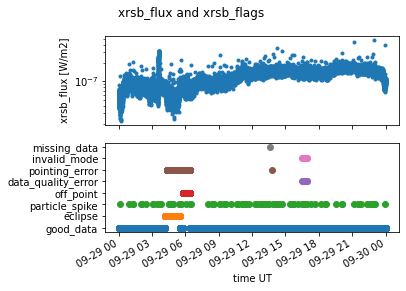

In [55]:
# This script demonstrates how to use the ncflag library to work with flags embedded in the XRS hires metadata. 
# In this example, we will be examining one day of high resolution 1-second data from the GOES-16 XRS. 
# XRS is measuring x-ray irradiance from the sun. We’ll summarize the flags, remove particle spikes, and zoom in 
# on an eclipse period where the Earth comes between the instrument and the sun and blocks the x-ray signal.
# To run this code, it may be necessary to update the filename version string (“v2-1-0”) to match available files.

filename = "sci_xrsf-l2-flx1s_g16_d20200929_v2-2-0.nc"

# Download `filename` if it does not exist locally
if not os.path.exists(filename):
    with open(filename, "wb") as f:
        url_path = "https://data.ngdc.noaa.gov/platforms/solar-space-observing-satellites/goes/goes16/l2/data/xrsf-l2-flx1s_science/2020/09/"
        r = requests.get(url_path + filename)
        f.write(r.content)

# Open and read some data from the netcdf file:
with nc.Dataset(filename) as nc_in:
    times = cftime.num2pydate(nc_in.variables["time"][:], nc_in.variables["time"].units)
    xrsb_flags = FlagWrap.init_from_netcdf(nc_in.variables["xrsb_flags"])
    xrsb_flux = np.ma.filled(nc_in.variables["xrsb_flux"][:], fill_value=np.nan)
    
# inspecting what flag_meanings are available and how many points are flagged for each of these flag meanings
for flag_meaning in xrsb_flags.flag_meanings:
    flags = xrsb_flags.get_flag(flag_meaning)
    num_set = np.count_nonzero(flags)
    print(f"{flag_meaning:<20}: {num_set}")
    
# a common task with flags is to get an overview of what flags are signaling at what points in time. 
# It’s convenient to plot this with matplotlib, along with the data.

plt.subplot(2, 1, 1)
plt.semilogy(times, xrsb_flux, linestyle="None", marker=".")
plt.ylabel("xrsb_flux [W/m2]")
plt.subplot(2, 1, 2)
for flag_meaning in xrsb_flags.flag_meanings:
    flags = xrsb_flags.get_flag(flag_meaning)
    if np.any(flags):
        flag_times = times[flags]
        flag_values = [flag_meaning for _ in range(len(flag_times))]
        plt.plot(flag_times, flag_values, ls="None", marker="o")

# Make sure there's room for the long flag_meaning names.
plt.gcf().autofmt_xdate()
plt.xlabel("time UT")
plt.subplots_adjust(left=0.3, right=0.98)
plt.suptitle("xrsb_flux and xrsb_flags")
plt.show()


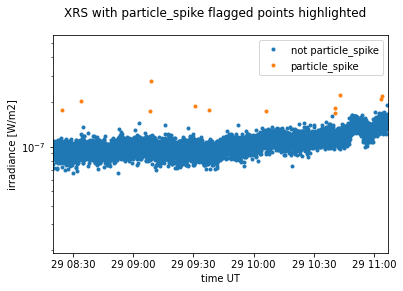

In [57]:
# There are a lot of flags on this particular day.
# (That’s why we picked it for this example!) 
# From the previous plot, some interesting features are visible:
# There are particle spikes throughout the day; There’s an eclipse early in the day,
# which is associated with some pointing flags; The instrument appears to have temporarily 
# entered an invalid mode about 3/4 the way through the day.

# Let's pick some portion near the middle of the day and zoom in on some particle spikes.
# We'll plot spikes and non spikes in different colors to see which points are flagged as spikes...

particle_spike = xrsb_flags.get_flag("particle_spike")
plt.semilogy(times[~particle_spike], xrsb_flux[~particle_spike],
             linestyle="None", marker=".", label="not particle_spike")
plt.semilogy(times[particle_spike], xrsb_flux[particle_spike],
             linestyle="None", marker=".", label="particle_spike")

# zoom in on some arbitrary period near the middle of the day...
plt.xlim(times[[30_000, 40_000]])

plt.legend()
plt.suptitle("XRS with particle_spike flagged points highlighted")
plt.xlabel("time UT")
plt.ylabel("irradiance [W/m2]")
plt.show()

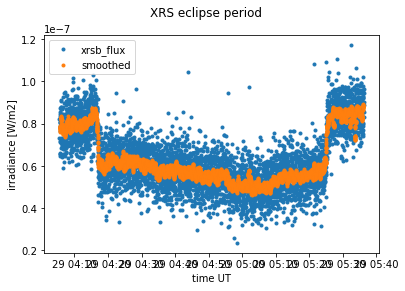

In [58]:
# We’re generally not interested in spikes, so let’s replace any point that is flagged as a 
# particle_spike with np.nan so that they are not included in further analysis and don’t show up on plots.

xrsb_flux[particle_spike] = np.nan

# As we saw above, there are are some eclipse flags set. 
# Let’s check out the irradiance observations to verify. 
# The Earth came between the instrument and the sun, so we shouldn’t see as much signal. 
# The remaining signal will be thermal noise and electron contamination.

# The eclipse is contiguous, so we’ll just take the start and end, +/- 300 points to include an extra 
# 5 minutes of the irradiance time series on each side, so that we can clearly see the transition into eclipse.

def running_mean(x, n):
    """
    Compute running mean of x with window size of n, handles nan values.

    https://stackoverflow.com/a/27681394

    :param x: 1D array of values
    :param n: window size
    :return: running mean with shape (len(x) - N)
    """
    cumsum = np.nancumsum(np.insert(x, 0, 0))
    return (cumsum[n:] - cumsum[:-n]) / float(n)

eclipse = xrsb_flags.get_flag("eclipse")
eclipse_start_index, eclipse_end_index = np.where(eclipse)[0][[0, -1]]
eclipse_slice = slice(eclipse_start_index - 300, eclipse_end_index + 300)

eclipse_times = times[eclipse_slice]
eclipse_xrsb = xrsb_flux[eclipse_slice]
plt.plot(eclipse_times, eclipse_xrsb,
         linestyle="none", marker=".", label="xrsb_flux")

smoothing_window = 15
eclipse_xrsb_smoothed = running_mean(eclipse_xrsb, smoothing_window)
plt.plot(
    eclipse_times[smoothing_window // 2:-(smoothing_window - 2) // 2],
    eclipse_xrsb_smoothed,
    linestyle="none", marker=".", label="smoothed")

plt.suptitle("XRS eclipse period")
plt.legend()
plt.xlabel("time UT")
plt.ylabel("irradiance [W/m2]")
plt.show()

In [59]:
# Eclipses are interesting, but they are not measurements of solar x-ray irradiance. 
# Most users of xrs data will _not_ be interested in eclipsed data. In fact, eclipses and other flagged 
# conditions will distort statistic. If you’re looking for genuine x-ray irradiance, you should only look 
# at points flagged as good_data. (Even better would be to look at the xrsf-l2-avg1m (1-minute average) product,
# which attempts to correct for electron contamination!)

# Mean of all data, before taking good_data only.
orig_xrsb_mean = np.nanmean(xrsb_flux)

# set any points that are NOT good_data to nan
good_data = xrsb_flags.get_flag("good_data")
xrsb_flux[~good_data] = np.nan

# Mean of good_data only.
xrsb_mean = np.nanmean(xrsb_flux)

print(f"Mean (all except spikes)             : {orig_xrsb_mean:0.2e} [W/m2]")
print(f"Mean (only good_data)                : {xrsb_mean:0.2e} [W/m2]")
print(f"Difference (good - all except spikes): {xrsb_mean - orig_xrsb_mean:0.2e} [W/m2]")

Mean (all except spikes)             : 1.20e-07 [W/m2]
Mean (only good_data)                : 1.24e-07 [W/m2]
Difference (good - all except spikes): 4.71e-09 [W/m2]


Filename:   sci_xrsf-l2-avg1m_g16_d20200601_v2-2-0.nc
start time in file [seconds since 2000-01-01 12:00:00]: 644241600.0
start and end times: 2020-06-01 00:00:00 2020-06-01 23:59:00
xrsa_flux[0]: 2.20548e-09
xrsa_flux_observed[0]: 6.10827e-09
satellite:  g16

All variable names
['xrsa_flux', 'xrsa_flux_observed', 'xrsa_flux_electrons', 'xrsb_flux', 'xrsb_flux_observed', 'xrsb_flux_electrons', 'xrsa_flag', 'xrsb_flag', 'xrsa_num', 'xrsb_num', 'time', 'xrsa_flag_excluded', 'xrsb_flag_excluded', 'au_factor', 'corrected_current_xrsb2', 'roll_angle', 'xrsa1_flux', 'xrsa1_flux_observed', 'xrsa1_flux_electrons', 'xrsa2_flux', 'xrsa2_flux_observed', 'xrsa2_flux_electrons', 'xrsb1_flux', 'xrsb1_flux_observed', 'xrsb1_flux_electrons', 'xrsb2_flux', 'xrsb2_flux_observed', 'xrsb2_flux_electrons', 'xrs_primary_chan', 'xrsa1_flag', 'xrsa2_flag', 'xrsb1_flag', 'xrsb2_flag', 'xrsa1_num', 'xrsa2_num', 'xrsb1_num', 'xrsb2_num', 'xrsa1_flag_excluded', 'xrsa2_flag_excluded', 'xrsb1_flag_excluded', 'xrsb2

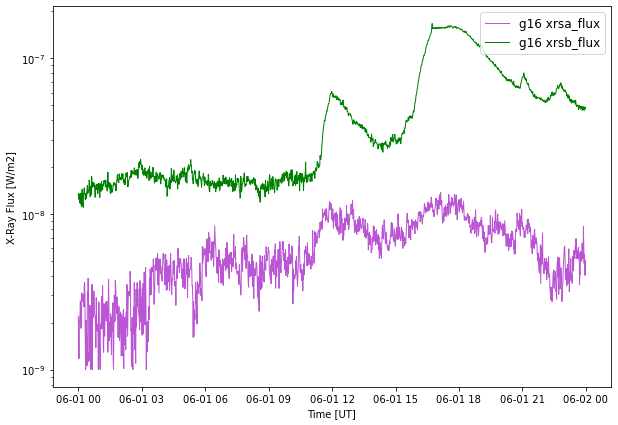

Done.



In [60]:
# This script demonstrates how to plot XRS 1min data.

num_vars = 2
make_plot = 1

# To run this code, it may be necessary to update the filename version string (“v2-1-0”) to match available files.

dir0 = "./"
file0 = "sci_xrsf-l2-avg1m_g16_d20200601_v2-2-0.nc"

# Download `file0` if it does not exist locally
if not os.path.exists(dir0 + file0):
    with open(dir0 + file0, "wb") as f:
        url_path = "https://data.ngdc.noaa.gov/platforms/solar-space-observing-satellites/goes/goes16/l2/data/xrsf-l2-avg1m_science/2020/06/"
        r = requests.get(url_path + file0)
        f.write(r.content)

# Open netcdf file for reading data

ff = nc.Dataset(dir0 + file0)

# Time conversion

datetime0 = cftime.num2pydate(ff.variables["time"][:], ff["time"].units)
print("Filename:  ", file0)
print("start time in file [{}]: {}".format(ff["time"].units, ff.variables["time"][0]))
print("start and end times:", datetime0[0], datetime0[-1])

# Print some variable names and values

for ii in np.arange(num_vars):
    var = list(ff.variables.keys())[ii]
    val = ff.variables[var][:]
    print("{}[0]: {:8g}".format(var, val[0]))
    
# Print a global attribute

platform = getattr(ff, "platform")
print("satellite: ", platform)

# Print all variable names

print("\nAll variable names")
print(list(ff.variables.keys()), "\n")

# Plot 1 day of XRS data

var_name = ["xrsa_flux", "xrsb_flux"]
if make_plot:
    chan_color = ["mediumorchid", "green", "darkviolet", "indigo", "b",
                  "darkcyan", "greenyellow", "yellow", "gold", "orange",
                  "orangered", "darkred"][0:num_vars]
    plt.figure(0, figsize=[10, 7])
    for ii in range(num_vars):
        plt.plot(
            datetime0[:],
            ff.variables[var_name[ii]][:],
            linewidth=1,
            color=chan_color[ii],
            label="{} {}".format(platform, var_name[ii]),
        )
    plt.yscale("log")
    plt.legend(loc="upper right", prop={"size": 12})
    plt.xlabel("Time [UT]")
    plt.ylabel("X-Ray Flux [{}]".format(ff[var_name[0]].units))
    plt.show()
print("Done.\n")




## ------------------------------------
## MAGNETIC FIELDS

- https://www.ncei.noaa.gov/products/goes-r-magnetometer
- https://www.ncei.noaa.gov/products/goes-1-15/space-weather-instruments
- Please refer to the documentation available at the GOES-R and GOES 1-15 /MAG websites

https://data.ngdc.noaa.gov/platforms/solar-space-observing-satellites/goes/goes16/l2/data/magn-l2-hires/2022/03/dn_magn-l2-hires_g16_d20220326_v1-0-1.nc
<Response [200]>


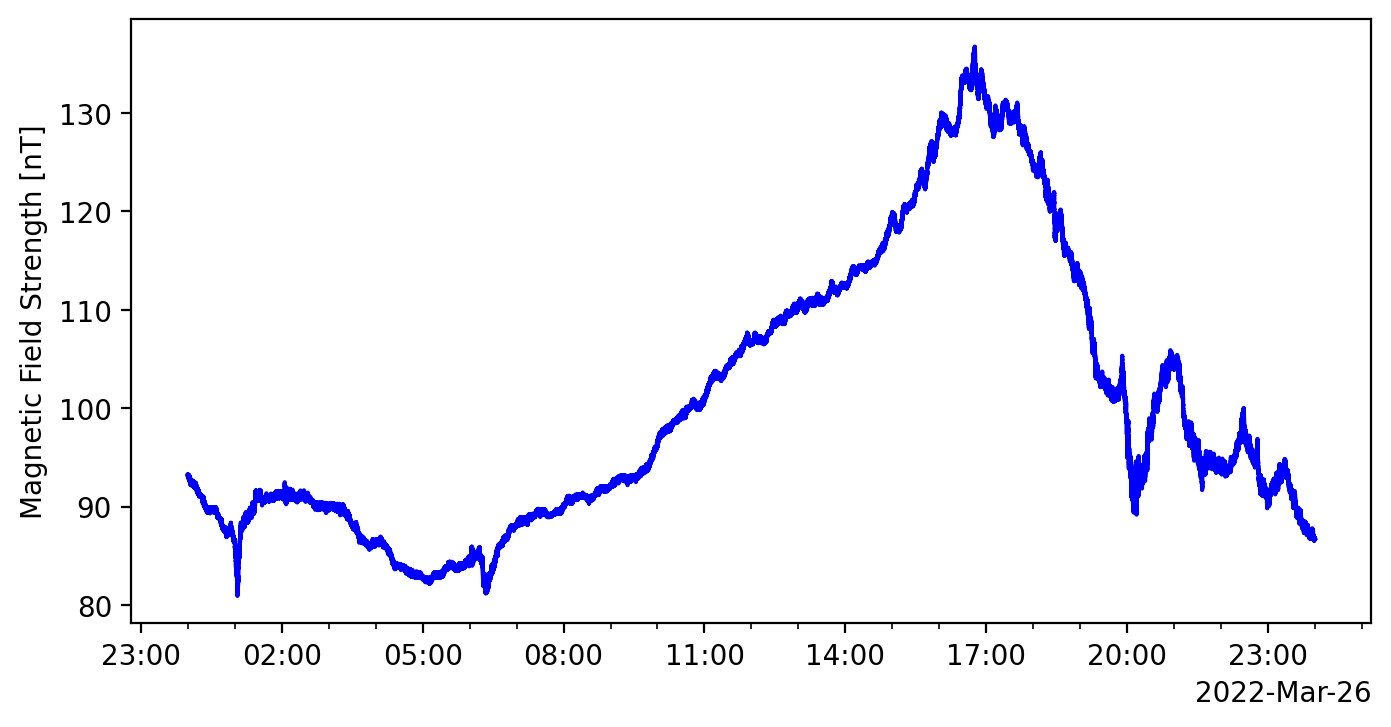

In [80]:
# reading and plotting MAG hires data

dataurl = 'https://data.ngdc.noaa.gov/platforms/solar-space-observing-satellites/goes/goes16/l2/data/magn-l2-hires'
subdir = '/2022/03/'
filename = "dn_magn-l2-hires_g16_d20220326_v1-0-1.nc"

if not os.path.exists(filename):
    with open(filename, "wb") as f:
        url_path = dataurl+subdir+filename
        print(url_path)
        r = requests.get(url_path)
        print(r)
        f.write(r.content)
        
# Read the magnetic field strength from the netCDF file

with nc.Dataset(filename) as ncf:

    dts = cftime.num2pydate(ncf.variables['time'][:],
                            ncf.variables['time'].units)

    B_total = ncf['b_total'][:]
    
# Plot the data

f,ax = plt.subplots(1,1,figsize=(8,4),dpi=200)

ax.plot(dts,B_total,'b-')
ax.set_ylabel('Magnetic Field Strength [nT]')

#Format the times nicely
locator = mdates.HourLocator(interval=3)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_minor_locator(mdates.HourLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator))

plt.show()


In [81]:
# defining functions

def butter_highpass(cutoff, fs, order):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data,cutoff,fs,order=5):
    b,a = butter_highpass(cutoff,fs,order=order)
    data_filt = signal.lfilter(b,a,data)
    return data_filt

def format_time_axis(ax):
    """Helper function; formats x-axis of plot with more readable times"""
    import matplotlib.dates as mdates
    locator = mdates.HourLocator(interval=3)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_minor_locator(mdates.HourLocator())
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator))

def read_nctime(ncfn,time_ncvar='time'):
    """Helper function; reads timestamps from a CF-compliant netCDF file
    and converts them to Python datetimes using cftime
    """
    with nc.Dataset(ncfn) as ncf:
        dts = cftime.num2pydate(ncf.variables[time_ncvar][:],
                                ncf.variables[time_ncvar].units)
    return dts

def read_ncotime(ncfn,time_ncvar='time_orbit'):
    """Helper function; reads timestamps from a CF-compliant netCDF file
    and converts them to Python datetimes using cftime
    """
    with nc.Dataset(ncfn) as ncf:
        dtso = cftime.num2pydate(ncf.variables[time_ncvar][:],
                                ncf.variables[time_ncvar].units)
    return dtso

def vdh_plot(ax,ncfn):
    """Plot magnetic field in VDH coordinate frame"""
    dts = read_nctime(ncfn)
    with nc.Dataset(filename) as ncf:
        B_vdh = ncf['b_vdh'][:]
    for cmpntcol,cmpnt in enumerate(['V','D','H']):
        ax.plot(dts,B_vdh[:,cmpntcol],label=f'{cmpnt} [nT]')
        ax.legend()
        format_time_axis(ax)
    ax.set_xlim(dts[0],dts[-1])


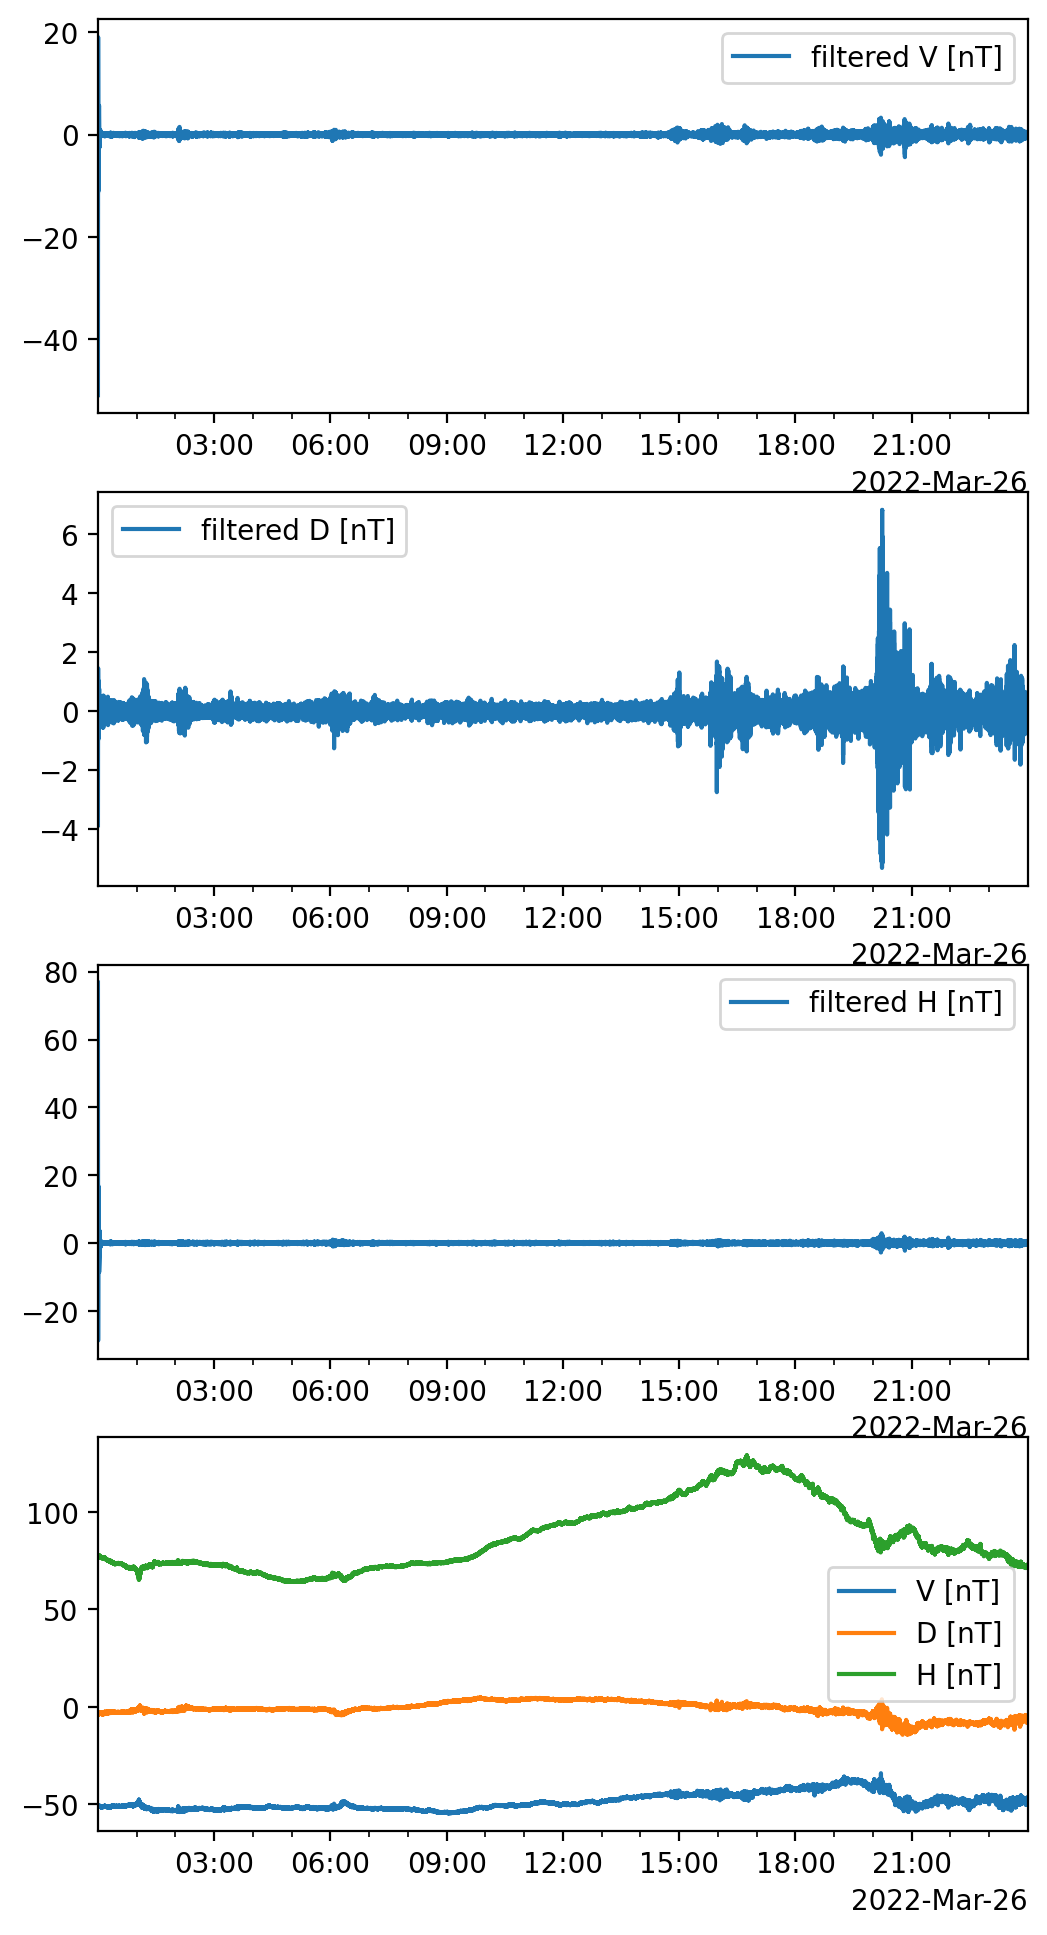

In [82]:
# Plotting highpass filtered highres MAG data in VDH coordinates

fs = 10 #sampling frequncy, Hz, usually 10 Hz for mag
cutoff=0.01 #cut off frequency
N = 1 #filter order
btype = 'high' #high or low pass filter
NFFT = 1024 #len of each fft segment
freqlim=1 # requency limit for plotting
db_min,db_max =-15, 20  #power level for plotting
str_plt, end_plt = 0, 1066 #start and end indexes for plotting, 0 and 1123 for full day

with nc.Dataset(filename) as ncf:
    B_vdh = ncf['b_vdh'][:]
    
    befilteredV = butter_highpass_filter(B_vdh[:,0], cutoff, fs, order=5)
    befilteredD = butter_highpass_filter(B_vdh[:,1], cutoff, fs, order=5)
    befilteredH = butter_highpass_filter(B_vdh[:,2], cutoff, fs, order=5)

f,axs = plt.subplots(4,1,figsize=(6,12),dpi=200)
vdh_plot(axs[3],filename)
axs[0].plot(dts,befilteredV,label='filtered V [nT]')
axs[0].legend()
format_time_axis(axs[0])
axs[0].set_xlim(dts[0],dts[-1])
axs[1].plot(dts,befilteredD,label='filtered D [nT]')
axs[1].legend()
format_time_axis(axs[1])
axs[1].set_xlim(dts[0],dts[-1])
axs[2].plot(dts,befilteredH,label='filtered H [nT]')
axs[2].legend()
format_time_axis(axs[2])
axs[2].set_xlim(dts[0],dts[-1])
plt.show()

/var/folders/b_/61wdb0j56pd7s29wdmr6__l9d8r7jn/T/ipykernel_4324/2565516595.py:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t,f,sg_db, cmap=cmap, vmin=db_min, vmax=db_max)


NameError: name 'matplotlib' is not defined

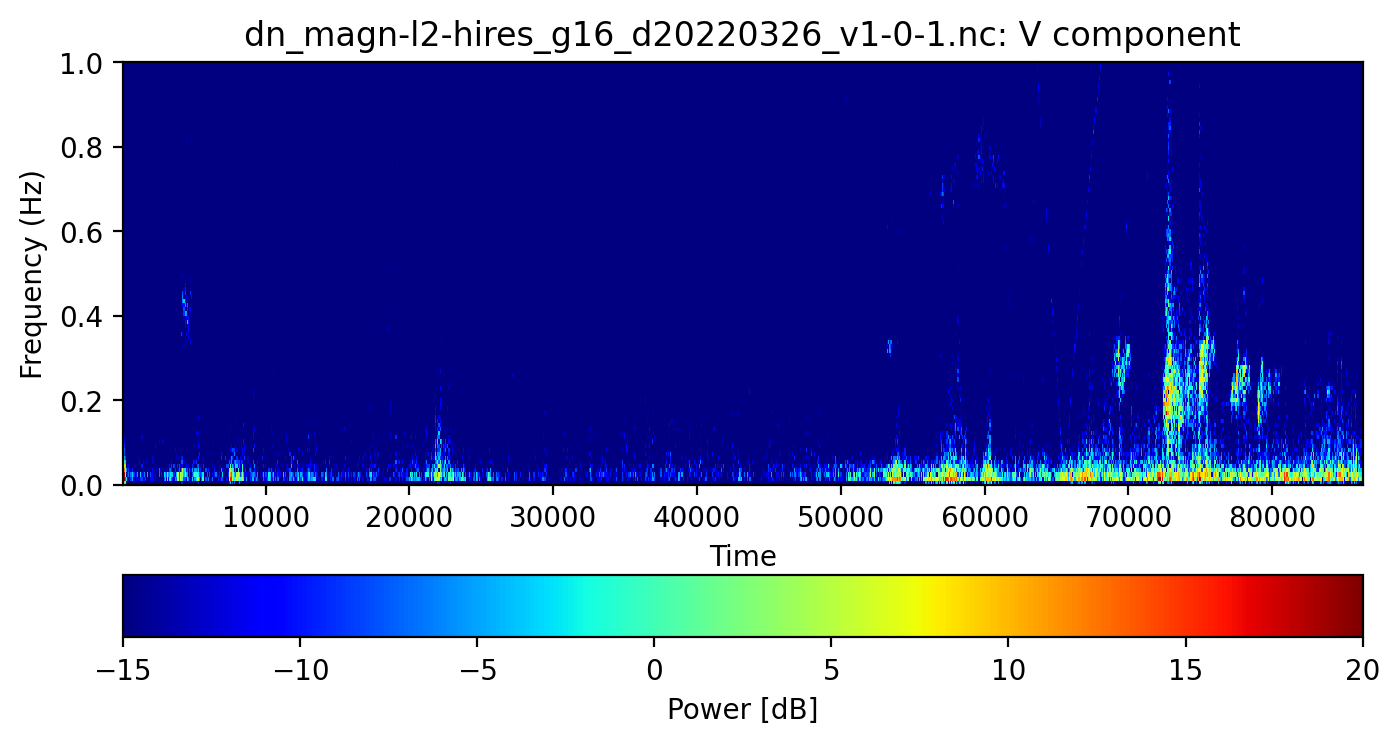

In [85]:
#plotting dynamic spectrum    

plt.subplots(1,1,figsize=(8,4),dpi=200)
plt.title(filename+': V component')
cmap =  plt.get_cmap('jet')
f, t, Sxx = signal.spectrogram(befilteredV, fs,
                                noverlap = NFFT / 4,
                                nperseg=NFFT,
                                detrend='linear')
sg_db = 10 * np.log10(Sxx)
plt.pcolormesh(t,f,sg_db, cmap=cmap, vmin=db_min, vmax=db_max)
plt.colorbar(orientation='horizontal',label='Power [dB]')
plt.ylim([0, freqlim])
#plt.xlim(57600,86399)
plt.ylabel("Frequency (Hz)")
plt.xlabel("Time")
formatter = matplotlib.ticker.FuncFormatter(timeTicks)
plt.gca().xaxis.set_major_formatter(formatter)

plt.subplots(1,1,figsize=(8,4),dpi=200)
plt.title(filename+': D component')
cmap =  plt.get_cmap('jet')
f, t, Sxx = signal.spectrogram(befilteredD, fs,
                                noverlap = NFFT / 4,
                                nperseg=NFFT,
                                detrend='linear')
sg_db = 10 * np.log10(Sxx)
plt.pcolormesh(t,f,sg_db, cmap=cmap, vmin=db_min, vmax=db_max)
#plt.colorbar(orientation='horizontal',label='Power [dB]')
plt.ylim([0, freqlim])
#plt.xlim(57600,86399)
plt.ylabel("Frequency (Hz)")
plt.xlabel("Time")
formatter = matplotlib.ticker.FuncFormatter(timeTicks)
plt.gca().xaxis.set_major_formatter(formatter)

plt.subplots(1,1,figsize=(8,4),dpi=200)
plt.title(filename+': H component')
cmap =  plt.get_cmap('jet')
f, t, Sxx = signal.spectrogram(befilteredH, fs,
                                noverlap = NFFT / 4,
                                nperseg=NFFT,
                                detrend='linear')
sg_db = 10 * np.log10(Sxx)
plt.pcolormesh(t,f,sg_db, cmap=cmap, vmin=db_min, vmax=db_max)
#plt.colorbar(orientation='horizontal',label='Power [dB]')
plt.ylim([0, freqlim])
#plt.xlim(57600,86399)
plt.ylabel("Frequency (Hz)")
plt.xlabel("Time")
formatter = matplotlib.ticker.FuncFormatter(timeTicks)
plt.gca().xaxis.set_major_formatter(formatter)



plt.show()

In [66]:
# Reading and plotting 1-min average MAG data and data quality flags (DQF)

# Quality information is available as specific quality flags (following the CF quality flag standard). 
# Note that flags which indicate possibly bad data begin with ‘potentially_degraded_due_to’ and 
# flags which indicate bad data begin with ‘degraded_due_to’. 
# The following demonstrates one way to visualize data quality using quality flags

dataurl = 'https://data.ngdc.noaa.gov/platforms/solar-space-observing-satellites/goes/goes16/l2/data/magn-l2-avg1m'
subdir = '/2023/02/'
filename = "dn_magn-l2-avg1m_g16_d20230201_v2-0-2.nc"  

# Download `filename` if it does not exist locally
if not os.path.exists(filename):
    with open(filename, "wb") as f:
        url_path = dataurl+subdir+filename
        print(url_path)
        r = requests.get(url_path)
        f.write(r.content)

print,filename

(<function print>, 'dn_magn-l2-avg1m_g16_d20230201_v2-0-2.nc')

In [71]:
# Defining functions
        
def read_cfflagvar(ncfn,flag_ncvar):
    """Read the values and required attributes for a
    CF-compliant data quality flag variable using ncflag"""
    with nc.Dataset(ncfn) as ncf:
        intflags = ncf.variables[flag_ncvar][:]
        fmeanings = ncf.variables[flag_ncvar].flag_meanings
        fvalues = ncf.variables[flag_ncvar].flag_values
        fmasks = ncf.variables[flag_ncvar].flag_masks
    return FlagWrap(intflags,fmeanings,fvalues,flag_masks=fmasks)



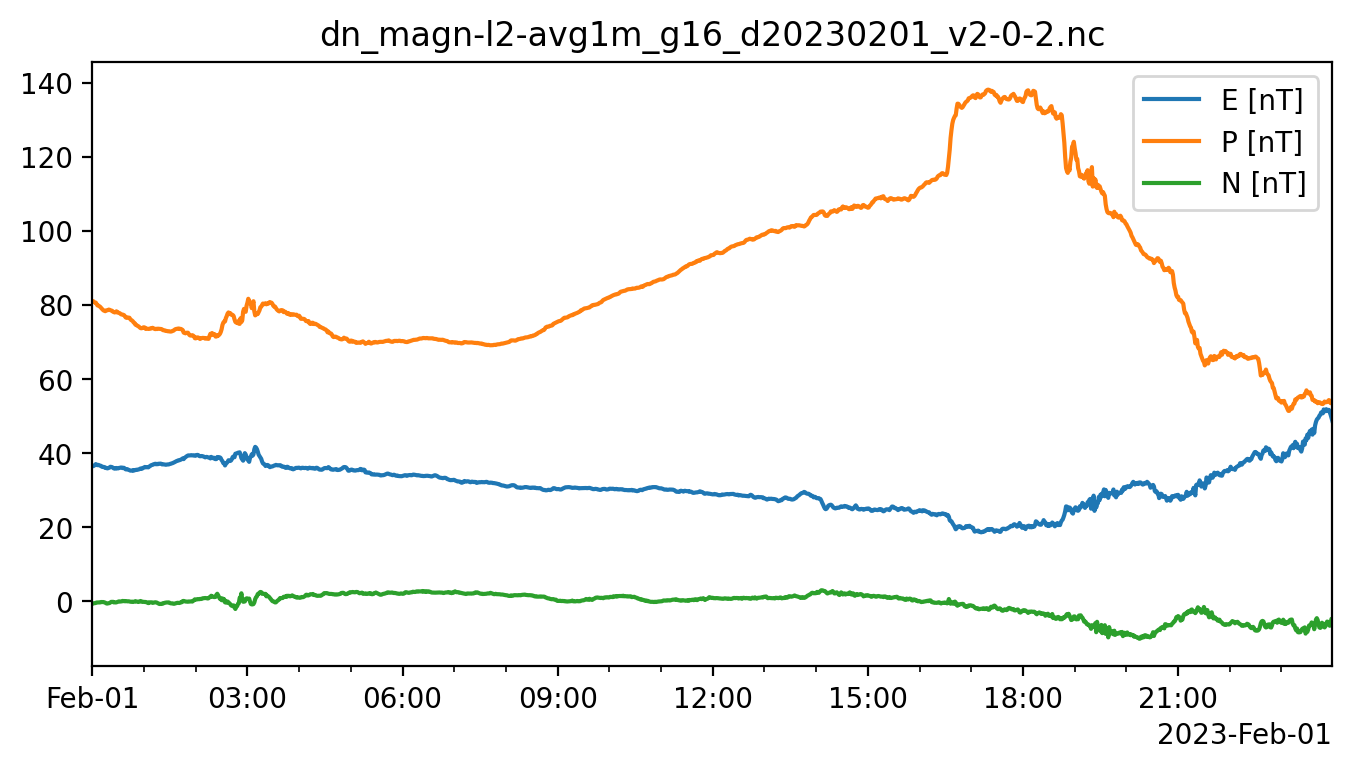

In [72]:
def mag_plot(ax,ncfn):
    """Plot magnetic field in EPN coordinate frame"""
    dts = read_nctime(ncfn)
    with nc.Dataset(filename) as ncf:
        B_epn = ncf['b_epn'][:]
    for cmpntcol,cmpnt in enumerate(['E','P','N']):
        ax.plot(dts,B_epn[:,cmpntcol],label=f'{cmpnt} [nT]')
        ax.legend()
        ax.set_title(filename)
        format_time_axis(ax)
    ax.set_xlim(dts[0],dts[-1])

f,ax = plt.subplots(1,1,figsize=(8,4),dpi=200)
mag_plot(ax,filename)
plt.show()

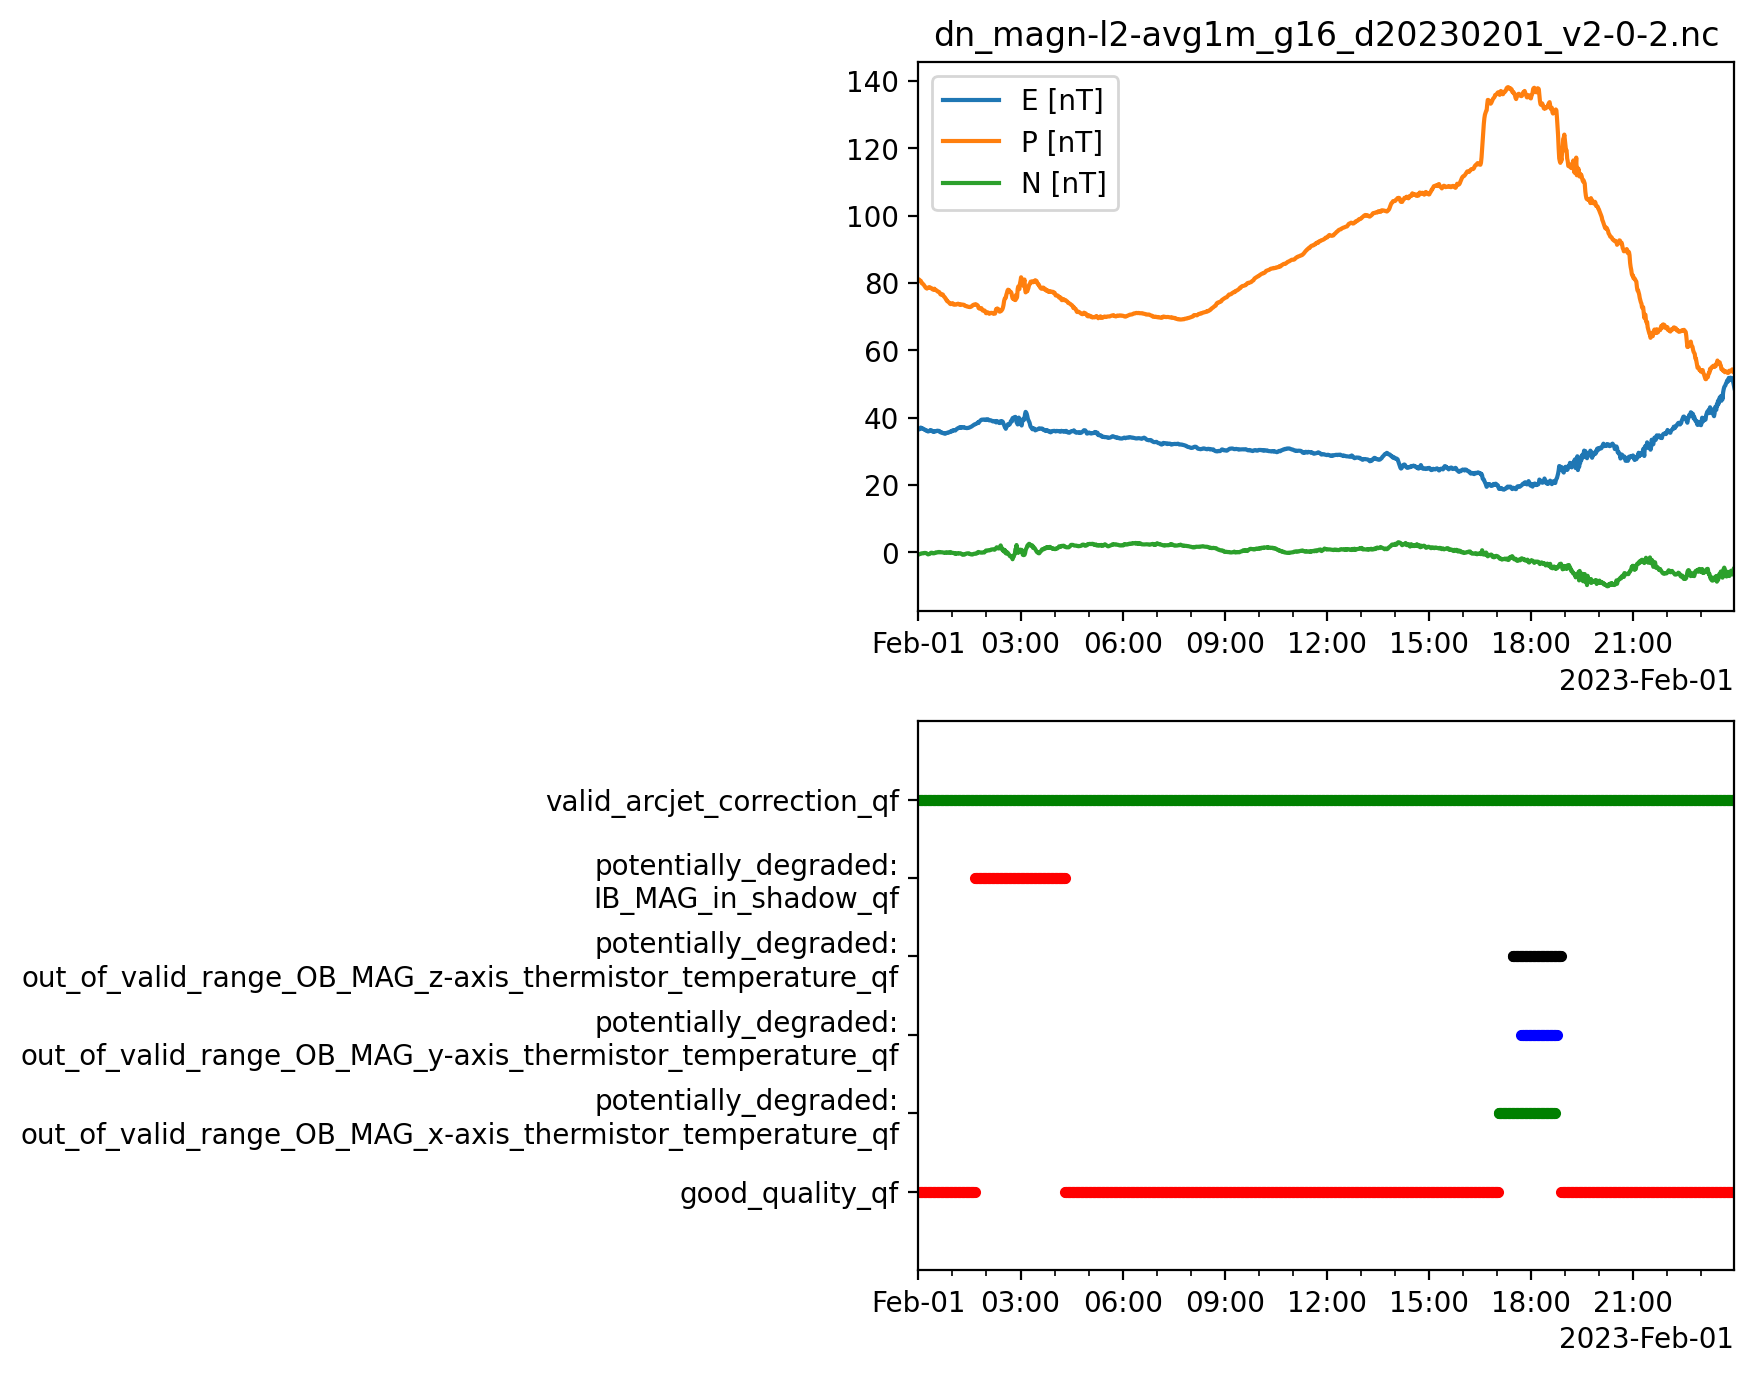

In [73]:
def flag_plot(ax,ncfn,ncvar,colors=['r', 'g', 'b','k']):
    """Plot CF-compliant data flags
    encoded in netCDF variable
    """
    from itertools import cycle
    #Read data
    t = read_nctime(ncfn)
    fw = read_cfflagvar(ncfn,ncvar)

    #Allocate loop-related variables
    nshown,shown_flag_meanings,shown_flag_labels = 0,[],[]
    nhidden,hidden_flag_meanings = 0,[]
    colorcycle = cycle(colors)

    #Loop over all possible flags
    for flag_key in fw.flag_meanings:
        #Returns a boolean array with True at all times
        #for which the flag is set
        flag_is_set = fw.get_flag(flag_key)
        if np.any(flag_is_set):
            nshown+=1
            shown_flag_meanings.append(flag_key)
            #Reformat long flag names
            if 'due_to' in flag_key:
                flag_label = ':\n'.join(flag_key.split('_due_to_'))
            else:
                flag_label = flag_key
            shown_flag_labels.append(flag_label)

            y = np.full((len(t),),np.nan)
            #plot points at y=nshown, so that they will
            #line up with the label for this flag on the y-axis
            y[flag_is_set] = nshown
            #Plot the data which has this flag set
            ax.plot(t,y,marker='.',linestyle='none',color=next(colorcycle))
        else:
            nhidden+=1
            hidden_flag_meanings.append(flag_key)

    #Format plot
    ax.set_ylim([0,nshown+1])
    ax.set_yticks(np.arange(1,nshown+1))
    ax.set_yticklabels(shown_flag_labels)
    ax.set_xlim(t[0],t[-1])
    format_time_axis(ax)
    
#good plot with flags    
f,axs = plt.subplots(2,1,figsize=(6,8),dpi=200)
mag_plot(axs[0],filename)
#vdh_plot(axs[1],filename)
flag_plot(axs[1],filename,'DQF')
#Ensure there is space for long data quality flag names
f.subplots_adjust(left=0.3, right=0.98)
plt.show()

## ------------------------------------
## PARTICLES

- https://www.ncei.noaa.gov/products/goes-r-space-environment-in-situ
- https://www.ncei.noaa.gov/products/goes-1-15/space-weather-instruments
- Please refer to the documentation available at the GOES-R/SEISS and GOES 1-15/particles websites

In [86]:
# Reading and plotting 1-min average MAG data and data quality flags (DQF)

# Quality information is available as specific quality flags (following the CF quality flag standard). 
# Note that flags which indicate possibly bad data begin with ‘potentially_degraded_due_to’ and 
# flags which indicate bad data begin with ‘degraded_due_to’. 
# The following demonstrates one way to visualize data quality using quality flags

dataurl = 'https://data.ngdc.noaa.gov/platforms/solar-space-observing-satellites/goes/goes16/l2/data/mpsh-l2-avg1m'
subdir = '/2020/06/'
filename = "sci_mpsh-l2-avg1m_g16_d20200601_v1-0-2.nc"  

# Download `filename` if it does not exist locally
if not os.path.exists(filename):
    with open(filename, "wb") as f:
        url_path = dataurl+subdir+filename
        print(url_path)
        r = requests.get(url_path)
        f.write(r.content)

print,filename

https://data.ngdc.noaa.gov/platforms/solar-space-observing-satellites/goes/goes16/l2/data/mpsh-l2-avg1m/2020/06/sci_mpsh-l2-avg1m_g16_d20200601_v1-0-2.nc


(<function print>, 'sci_mpsh-l2-avg1m_g16_d20200601_v1-0-2.nc')

In [89]:
ds = nc.Dataset(filename)
times = cftime.num2pydate(ds.variables["L2_SciData_TimeStamp"][:], ds["L2_SciData_TimeStamp"].units)
print("start and end times:", times[0], times[-1])
print("\nAll variable names: ")
print(list(ds.variables.keys()), "\n")

start and end times: 2020-06-01 00:00:00 2020-06-01 23:59:00

All variable names: 
['L2_SciData_TimeStamp', 'L1bRecordsInAvg', 'YawFlipFlag', 'EclipseFlag', 'AvgDiffProtonFlux', 'AvgDiffProtonFluxUncert', 'DiffProtonValidL1bSamplesInAvg', 'DiffProtonDQFdtcSum', 'DiffProtonDQFoobSum', 'DiffProtonDQFerrSum', 'AvgDiffElectronFlux', 'AvgDiffElectronFluxUncert', 'DiffElectronEffectiveEnergy', 'DiffElectronValidL1bSamplesInAvg', 'DiffElectronDQFdtcSum', 'DiffElectronDQFoobSum', 'DiffElectronDQFerrSum', 'AvgIntElectronFlux', 'AvgIntElectronFluxUncert', 'IntElectronEffectiveEnergy', 'IntValidL1bSamplesInAvg', 'IntDQFdtcSum', 'IntDQFoobSum', 'IntDQFerrSum', 'DiffProtonLowerEnergy', 'DiffProtonUpperEnergy', 'DiffProtonEffectiveEnergy', 'ExpectedLUTNotFound'] 



/Users/alessandra.pacini/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:171: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)


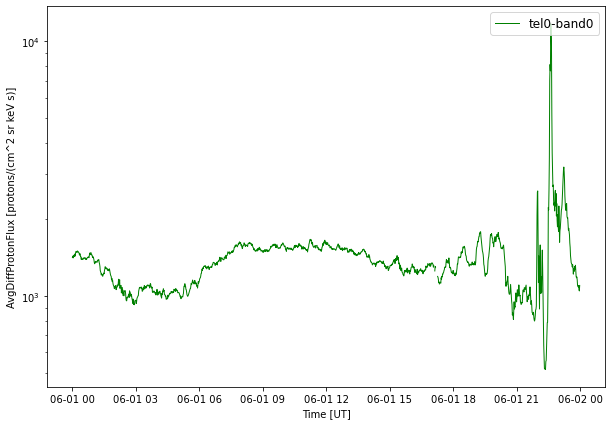

Done.



In [90]:
# Plot 1 day of MPSH 1-minute AvgDiffProtonFlux in Telescope 0, Band 0

var = 'AvgDiffProtonFlux'
tel = 0
band = 0
data = []
for i in range(0, len(times)):
    data.append(ds.variables[var][i][tel][band])
plt.figure(0, figsize=[10, 7])
plt.plot(
    times[:],
    data,
    linewidth=1,
    color="green",
    label=f"tel{tel}-band{band}",
)
plt.yscale("log")
plt.legend(loc="upper right", prop={"size": 12})
plt.xlabel("Time [UT]")
plt.ylabel(f"{var} [{ds[var].units}]")
plt.show()
print("Done.\n")